# IMPORTS
- Bibliotecas utilizadas no projeto

In [1]:
import math
import pickle
import datetime
import warnings
import inflection
import numpy                as np
import pandas               as pd
import xgboost              as xgb
import seaborn              as sns
import matplotlib.pyplot    as plt
import matplotlib.gridspec  as gs

from scipy                  import stats     as ss
from IPython.display        import Image
from boruta                 import BorutaPy
from IPython.core.display   import display, HTML
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics        import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## Helps Functions

In [2]:
def jupyter_settings():
    warnings.filterwarnings('ignore')
    #%matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

# calcula a correlação entre variáveis categóricas
def cramer_v (x,y):
    """
    Função que calcula a correlação entre duas
    variáveis categóricas. 
    
    >>> number of the corr
    """
    
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    
    chi2corr = max( 0, chi2 - ( k-1 ) * ( r-1 ) / (n-1) )
    kcorr = k - ( k - 1 )**2 / (n - 1)
    rcorr = r - ( r - 1 )**2 / (n - 1)
    
    return np.sqrt( (chi2corr/n ) / (min(kcorr - 1, rcorr-1)) );


# mean_percentage_error
def mean_percentage_error(y, yhat):
    return np.mean( ( y - yhat ) / y )


# Função para criar o dataframe com a avaliação dos modelos
def ml_error(model_name, y, yhat):
    
    """
    Cria o dataframe com as métricas de avaliações dos modelos
    
    >>> DataFrame
    """
    
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({
        'Model name: ': model_name,
        'Mae: ':mae,
        'Mape: ':mape,
        'RMSE: ': rmse
    }, index = [0])

# funcao de validação cruzada
def cross_validation(xtraining, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        
        if verbose:
            print('\nK Fold: {}'.format(k))
            
        # start and end date for validation 
        validation_start_date = xtraining['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = xtraining['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        train = xtraining[xtraining['date'] < validation_start_date]
        validation = xtraining[(xtraining['date'] >= validation_start_date) & (xtraining['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtrain = train.drop(['date','sales'], axis=1)
        ytrain = train['sales']

        # validation
        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        # model
        md = model.fit(xtrain,ytrain)

        # predict
        y_hat= md.predict(xvalidation)

        # performance
        m_result_cv = ml_error(model_name, np.expm1(yvalidation), np.expm1(y_hat))

        # armazena a performance de cada kfold
        mae_list.append( m_result_cv['Mae: '] )
        mape_list.append( m_result_cv['Mape: '] )
        rmse_list.append( m_result_cv['RMSE: '] )

    # cria dataframe
    return pd.DataFrame({'Model Name ': model_name,
                         'MAE CV':round(np.mean(mae_list),2).astype(str) +' +/- '+ round(np.std(mae_list),2).astype(str),
                         'MAPE CV':round(np.mean(mape_list),2).astype(str) +' +/- '+ round(np.std(mape_list),2).astype(str),
                         'RMSE CV':round(np.mean(rmse_list),2).astype(str) + ' +/- '+ round(np.std(rmse_list),2).astype(str)}, index=[0])

## Load Data


In [3]:
path_project = '/home/nataniel/dev/data-science/projetos-portfolio/nps-rossmann-store-sales/'

df_sales_raw = pd.read_csv(path_project + 'data/train.csv', low_memory=False)
df_store_raw = pd.read_csv(path_project + 'data/store.csv', low_memory=False)

#merge 
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# DESCRIÇÃO DOS DADOS

In [4]:
# Cria uma cópia dos dados
df1 = df_raw.copy()

## Rename columns

In [5]:
# get columns name
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# rename cols
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df1.columns = cols_new

## Data Dimension

In [6]:
print (' Number of Rows: {}'.format(df1.shape[0]))
print (' Number of Cols: {}'.format(df1.shape[1]))

 Number of Rows: 1017209
 Number of Cols: 18


## Data Types change

In [7]:
df1['date'] = pd.to_datetime(df1['date'])

## Fillout NA

In [8]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].fillna(2000)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year
                                               if math.isnan(x['competition_open_since_year'])
                                               else x['competition_open_since_year'], axis=1)
# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week
                                     if math.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'], axis=1)
# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year
                                     if math.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'], axis=1)

# promo_interval
df1['promo_interval'].fillna(0, inplace=True)

# month_map
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'Mai', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map)

# is_promo
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1
    if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## Change Types

In [9]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [10]:
# change type float for int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## Descriptive statistical

### Numerical Attributes

In [11]:
# create dataframe with specific types
num_atributtes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float','datetime64[ns]'])

In [12]:
# mean values
ct1 = pd.DataFrame(num_atributtes.apply( np.mean ) ).T

In [13]:
## Central Tendency - mean, median
ct1 = pd.DataFrame(num_atributtes.apply( np.mean ) ).T
ct2 = pd.DataFrame(num_atributtes.apply( np.median ) ).T

## Dispersion
d1 = pd.DataFrame(num_atributtes.apply( np.std ) ).T
d2 = pd.DataFrame(num_atributtes.apply( np.min ) ).T
d3 = pd.DataFrame(num_atributtes.apply( np.max ) ).T
d4 = pd.DataFrame(num_atributtes.apply( lambda x: x.max()- x.min() ) ).T
d5 = pd.DataFrame(num_atributtes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_atributtes.apply( lambda x: x.kurtosis() ) ).T

# Concate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

attributes     min      max    range         mean  median          std      skew    kurtosis
0                          store     1.0   1115.0   1114.0   558.429727   558.0   321.908493 -0.000955   -1.200524
1                    day_of_week     1.0      7.0      6.0     3.998341     4.0     1.997390  0.001593   -1.246873
2                          sales     0.0  41551.0  41551.0  5773.818972  5744.0  3849.924283  0.641460    1.778375
3                      customers     0.0   7388.0   7388.0   633.145946   609.0   464.411506  1.598650    7.091773
4                           open     0.0      1.0      1.0     0.830107     1.0     0.375539 -1.758045    1.090723
5                          promo     0.0      1.0      1.0     0.381515     0.0     0.485758  0.487838   -1.762018
6                 school_holiday     0.0      1.0      1.0     0.178647     0.0     0.383056  1.677842    0.815154
7           competition_distance    20.0  75860.0  75840.0  5421.176681  2320.0  7707.271425  2.933327   13.038886
8   competition_open_since_month     1.0     12.0     11.0     6.786849     7.0     3.311085 -0.042076   -1.232607
9    competition_open_since_year  1900.0   2015.0    115.0  2010.324840  2012.0     5.515591 -7.235657  124.071304
10                        promo2     0.0      1.0      1.0     0.500564     1.0     0.500000 -0.002255   -1.999999
11             promo2_since_week     1.0     52.0     51.0    23.619033    22.0    14.310057  0.178723   -1.184046
12             promo2_since_year  2009.0   2015.0      6.0  2012.793297  2013.0     1.662657 -0.784436   -0.210075
13                      is_promo     0.0      1.0      1.0     0.143345     0.0     0.350425  2.035562    2.143516

### Categorical Attributes

In [14]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

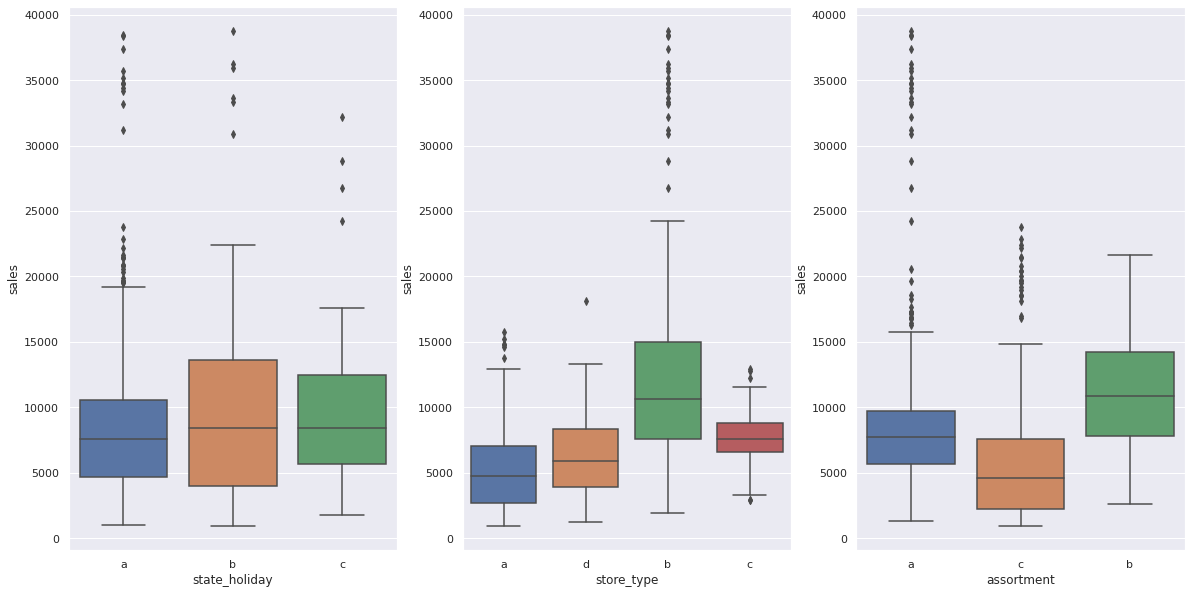

In [15]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1);

# FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## Mapa mental de hipóteses

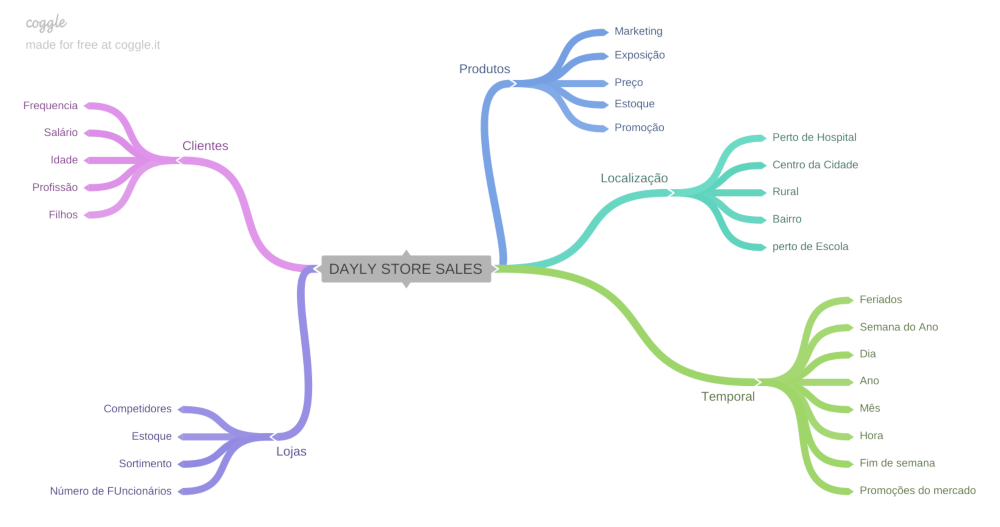

In [17]:
Image(path_project + 'docs/DAYLY_STORE_SALES.png')

## Criação de hipóteses

### Hipóteses das Lojas

**1.** Lojas com maior número de funcionários deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior competidores mais próximos deveriam vender mais

**4.** Lojas com menor porte deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais

### Hipóteses do Produto

**1.** Lojas que investem mais em marketing deveriam verder mais

**2.** Lojas que expôe os produtos na vitrine deveriam vender mais

**3.** Lojas que tem menores preços deveriam vender mais

**4.** Lojas que tem preços menores nos produtos por mais tempo deveriam vender mais

### Hipóteses do Tempo

**1.** Lojas que tem mais feriados deveriam vender menos

**2.** Lojas que abrem nos primeiros seis meses deveriam vender mais

**3.** Lojas que abrem nos finais de semana deveriam vender mais

**5.** Lojas com maior sortimento deveriam vender mais

## Feature Engineering

In [18]:
# year
df2['year'] = df2['date'].dt.year

# day
df2['day'] = df2['date'].dt.day

# month
df2['month'] = df2['date'].dt.month

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
    year=x['competition_open_since_year'],
    month=x['competition_open_since_month'], day=1), axis=1)

#competition_time_month
df2['competition_time_month'] = (
    (df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(
    x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# promo_time_week
df2['promo_time_week'] = (
    (df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# FILTRAGEM DE VARIÁVEIS

In [19]:
df3 = df2.copy()

### Filtragem das linhas

In [20]:
# remove data with 0 sales 
df3 = df3[df3['sales'] > 0]

### Seleção das colunas

In [21]:
# delete features useless for model
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# ANÁLISE EXPLORATÓRIA DOS DADOS

In [22]:
df4 =  df3.copy()

## Análise Univariada

### Response variable

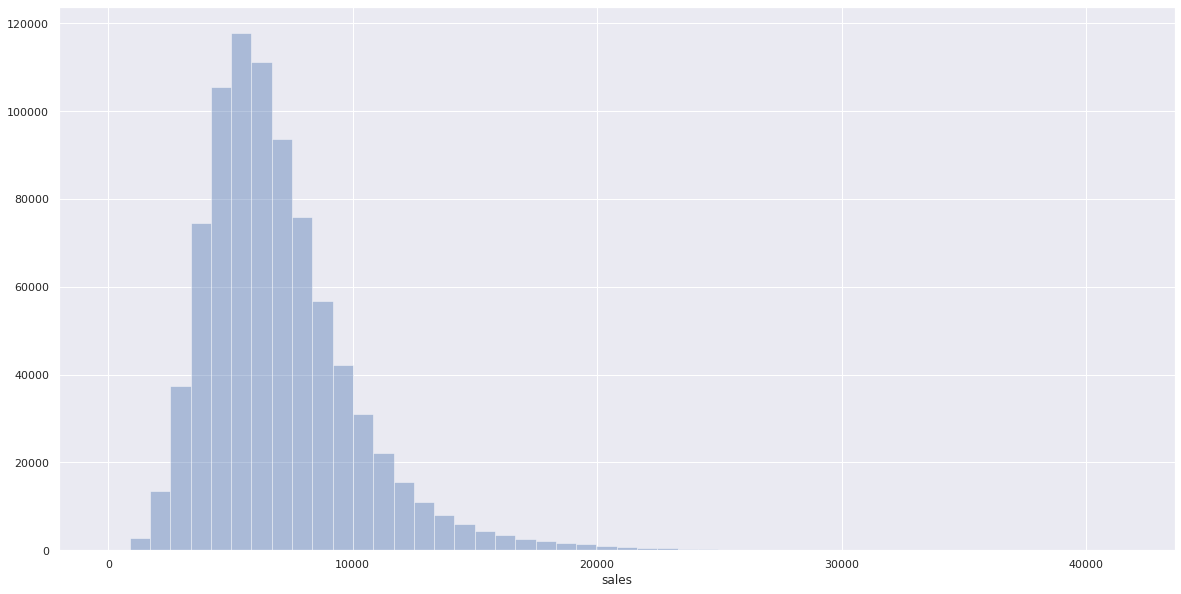

In [23]:
sns.distplot(df4['sales'], kde=False);

### Numerival variables

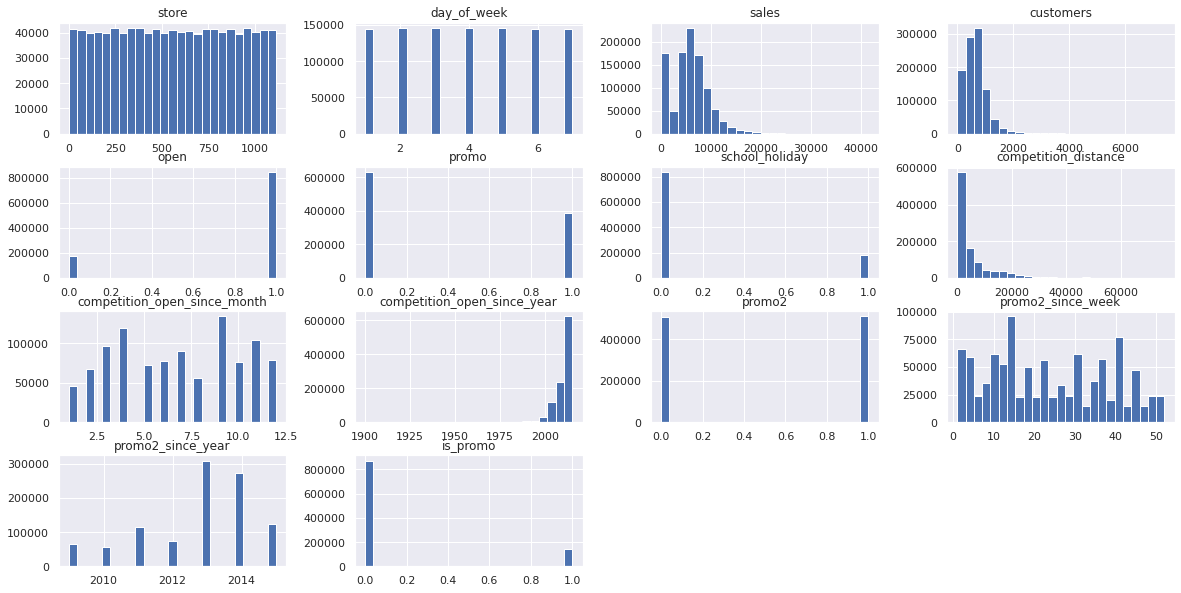

In [24]:
num_atributtes.hist(bins=25);

### Categorical variables

In [25]:
cat_attributes.head()

state_holiday store_type assortment   promo_interval month_map
0             0          c          a                0       Jul
1             0          a          a  Jan,Apr,Jul,Oct       Jul
2             0          a          a  Jan,Apr,Jul,Oct       Jul
3             0          c          c                0       Jul
4             0          a          a                0       Jul

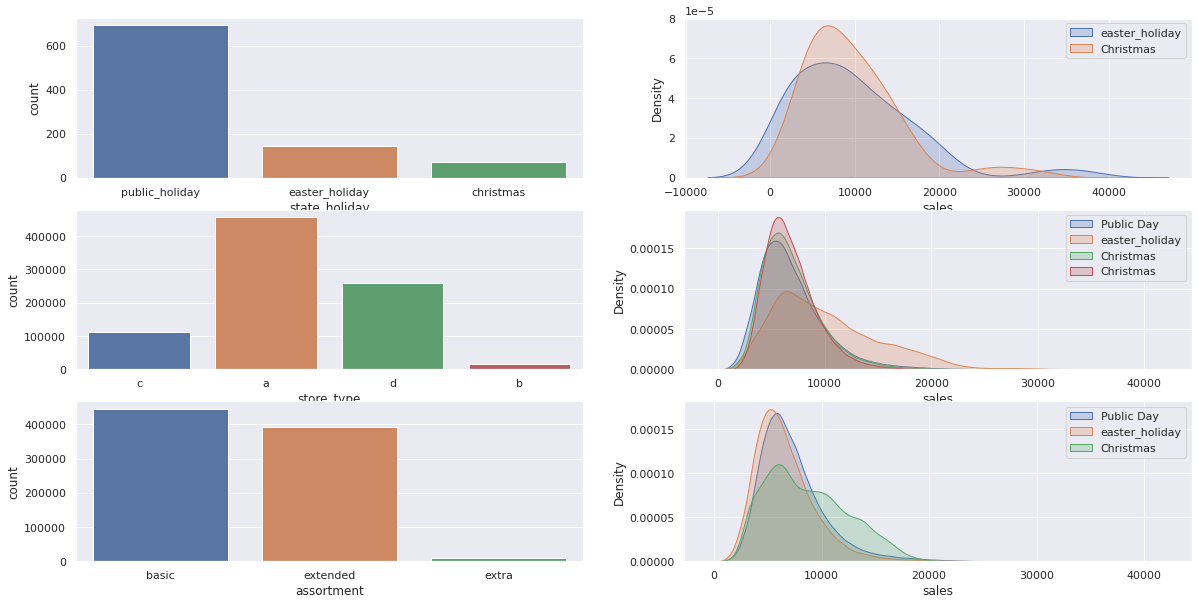

In [26]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(data=df4[df4['state_holiday'] == 'public_day']
            ['sales'], label='Public Day', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'easter_holiday']
            ['sales'],label='easter_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'christmas']
            ['sales'], label='Christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(data=df4[df4['store_type'] == 'a']
            ['sales'], label='Public Day', shade=True, legend=True)
sns.kdeplot(data=df4[df4['store_type'] == 'b']
            ['sales'],label='easter_holiday', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'c']
            ['sales'], label='Christmas', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'd']
            ['sales'], label='Christmas', shade=True);
plt.legend()

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(data=df4[df4['assortment'] == 'extended']
            ['sales'], label='Public Day', shade=True, legend=True)
sns.kdeplot(data=df4[df4['assortment'] == 'basic']
            ['sales'],label='easter_holiday', shade=True)
sns.kdeplot(data=df4[df4['assortment'] == 'extra']
            ['sales'], label='Christmas', shade=True);
plt.legend();

## Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais
**Falsa** Lojas com maior sortimento vendem MENOS

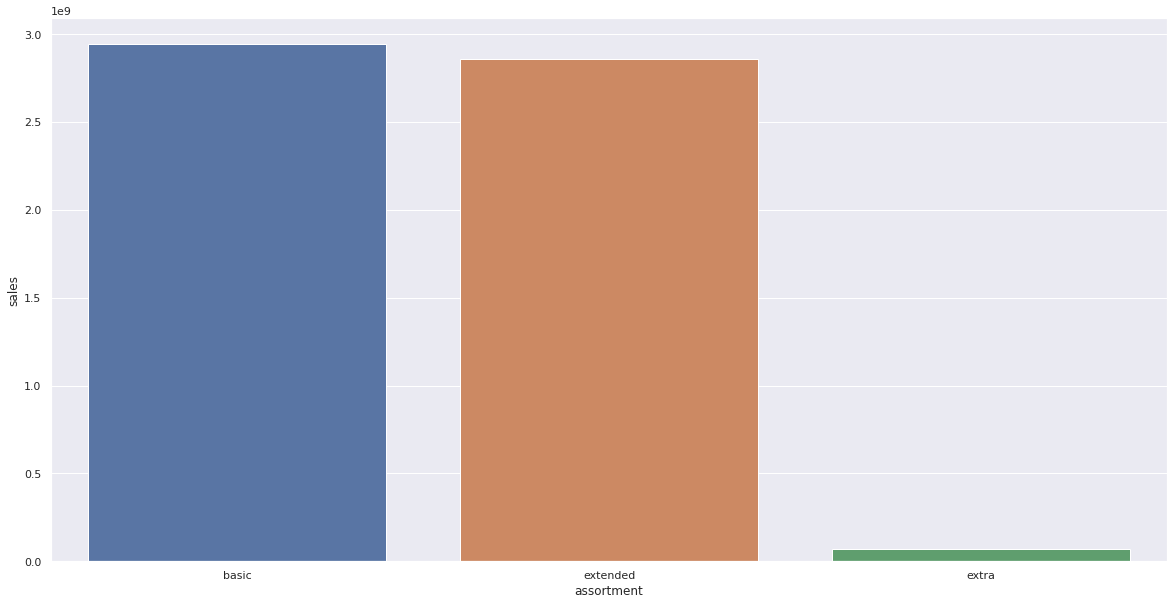

In [27]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x=aux1['assortment'], y=aux1['sales'], data=aux1);

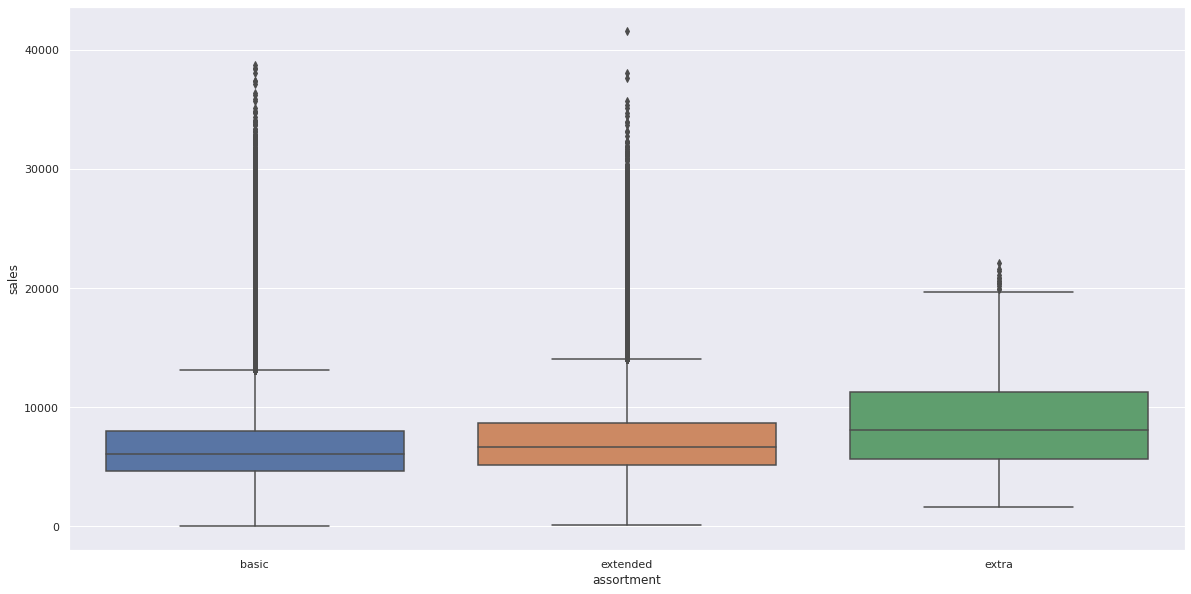

In [28]:
sns.boxplot(x=df4['assortment'], y=df4['sales'], data=df4);

### **H2.** Lojas com maior competidores mais próximos deveriam vender menos
**Falsa** Lojas com competidores mais próximos vendem MAIS


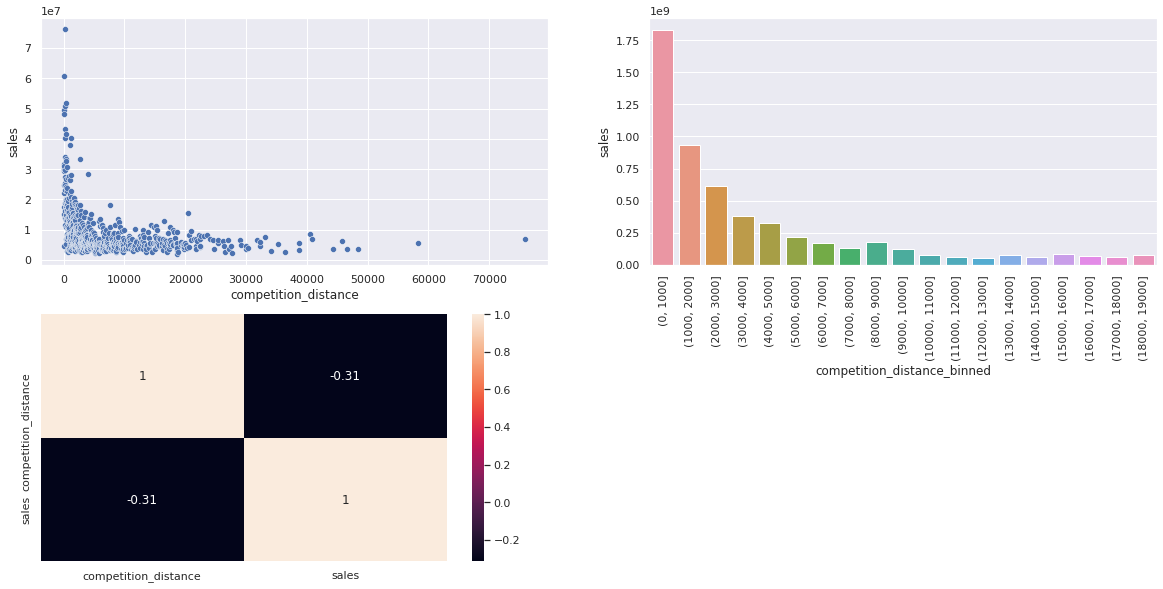

In [29]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(2,2,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vender mais
**Falsa** Lojas com competidores á mais tempo vendem MENOS

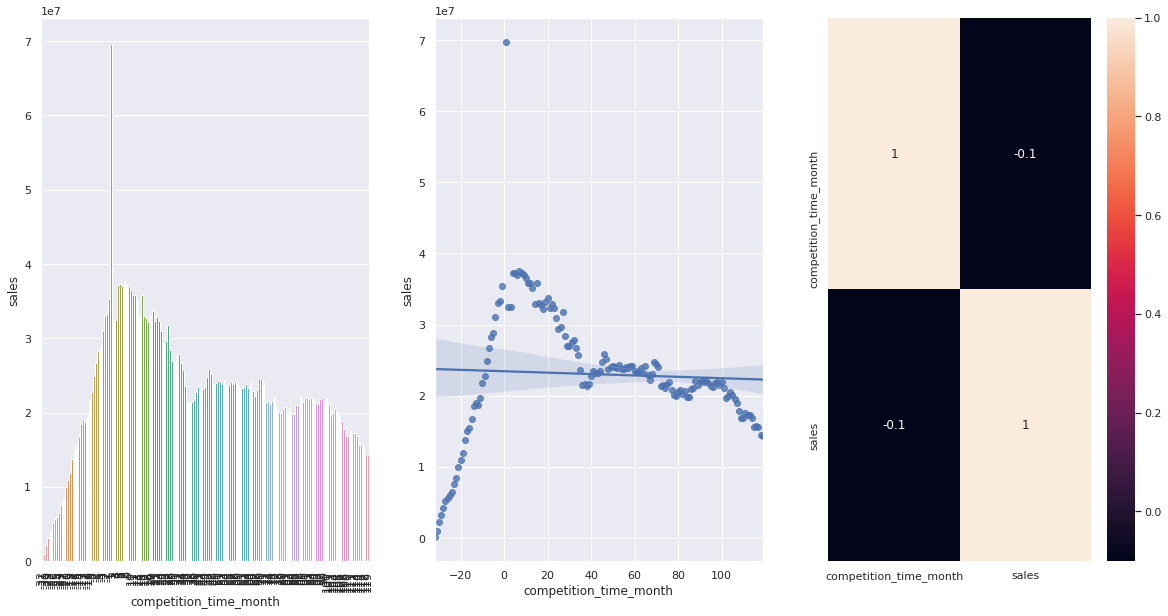

In [30]:
# calcula a diferença de tempo em dias
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais
**Falsa** Lojas com promoções ativas por mais tempo vendem MENOS depois de um certo período de promoção

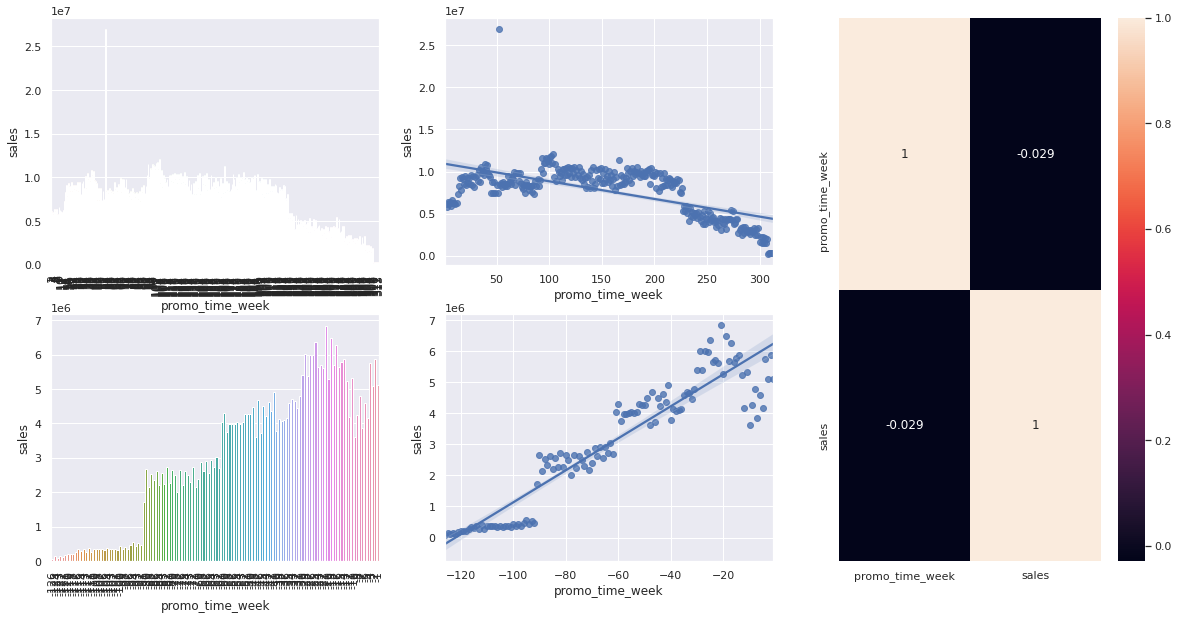

In [31]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

aux2 = aux1[aux1['promo_time_week'] > 0]
aux3 = aux1[aux1['promo_time_week'] < 0]

grid = gs.GridSpec(2,3)

plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks( rotation=90 )

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks( rotation=90 );

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais </s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais
**Falsa** Lojas com promoçoes consecutivas vendem menos

In [32]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values(by='sales')

promo  promo2       sales
1      0       1  1289362241
3      1       1  1472275754
0      0       0  1482612096
2      1       0  1628930532

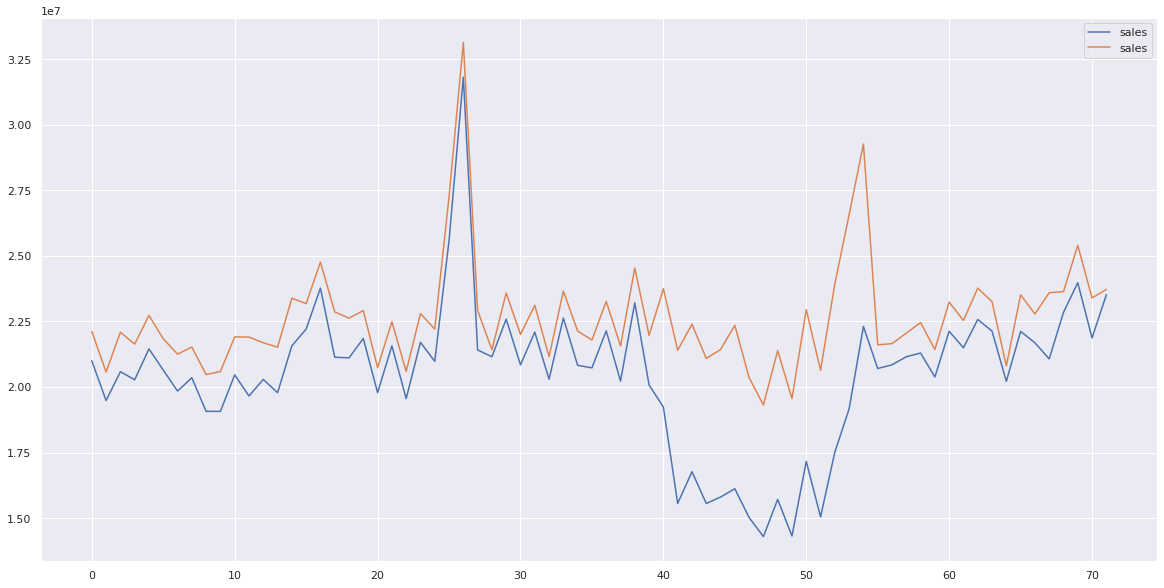

In [33]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais
**Falsa** Lojas abertas durante o natal NÃO vendem mais

In [34]:
holiday_christmas = df4[df4['state_holiday'] == 'christmas']

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

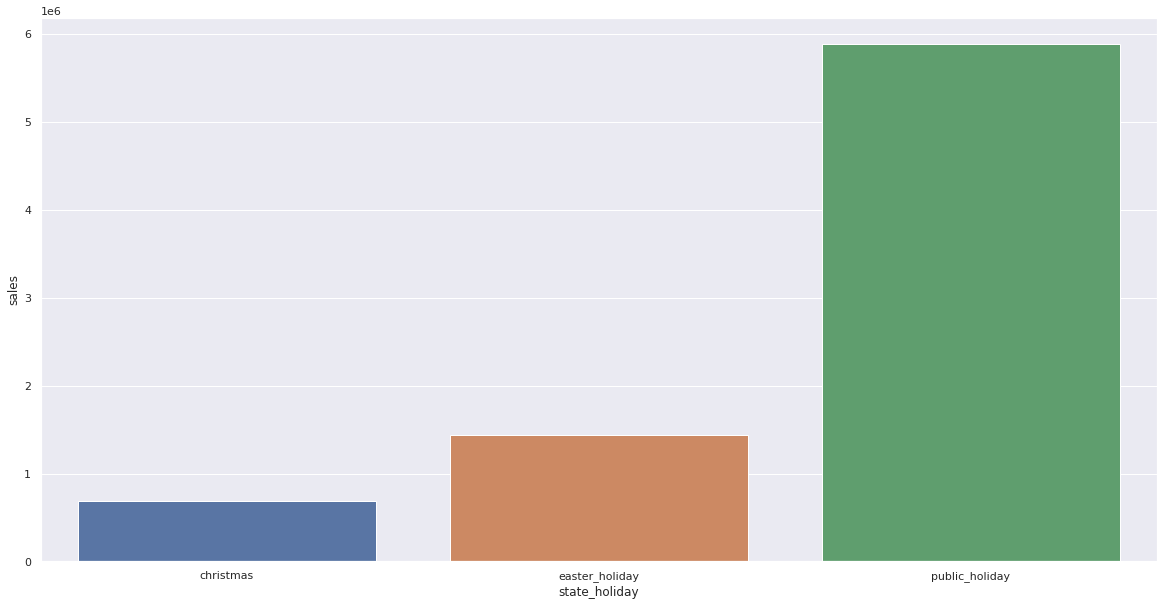

In [35]:
aux1 = df4[df4['state_holiday'] != 'regular_day']
aux = aux1[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x=aux['state_holiday'], y=aux['sales'], data=aux)

<AxesSubplot:xlabel='year', ylabel='sales'>

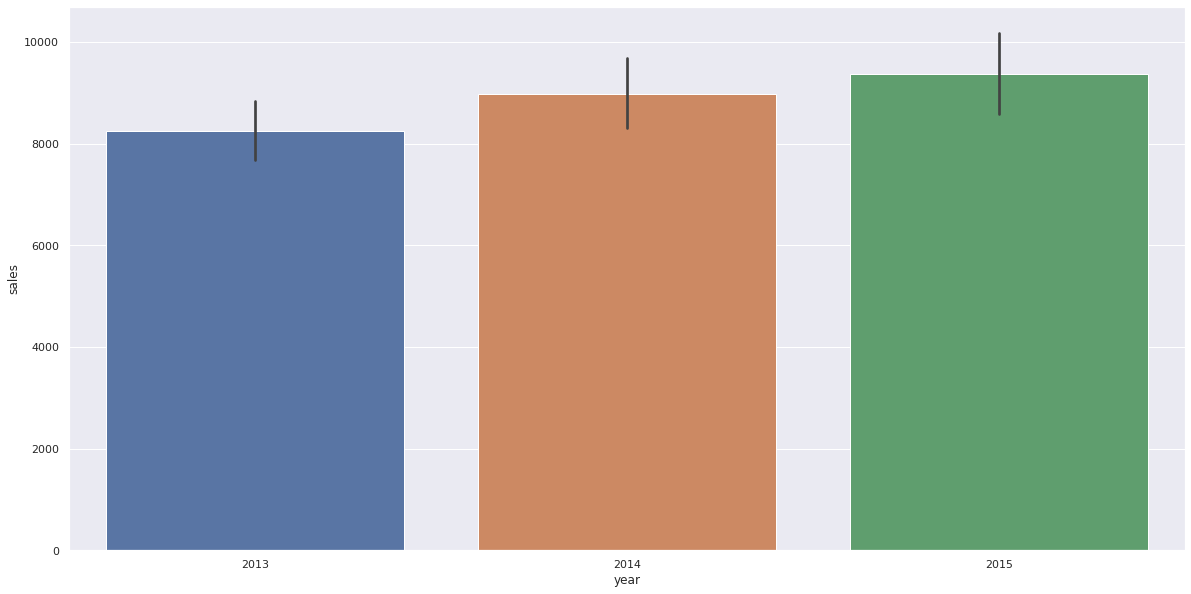

In [36]:
aux1[['year','state_holiday','sales']].groupby('sales').sum().reset_index()
sns.barplot(x='year',y='sales',data=aux1)

### **H8.** Lojas deveriam vender mais ao longo dos anos
**Falsa** Lojas vendem menos ao longo dos anos

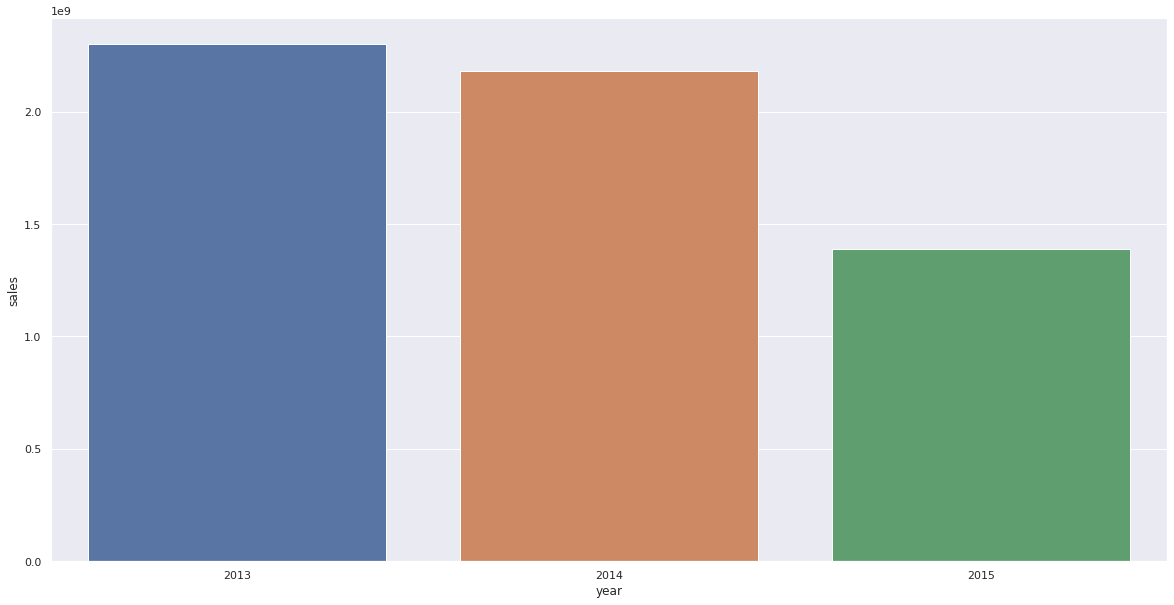

In [37]:
aux = df4[['sales','year']].groupby('year').sum().reset_index()
sns.barplot(x='year',y='sales',data=aux);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano
**Falsa** Lojas vendem menos no segundo semestre do ano

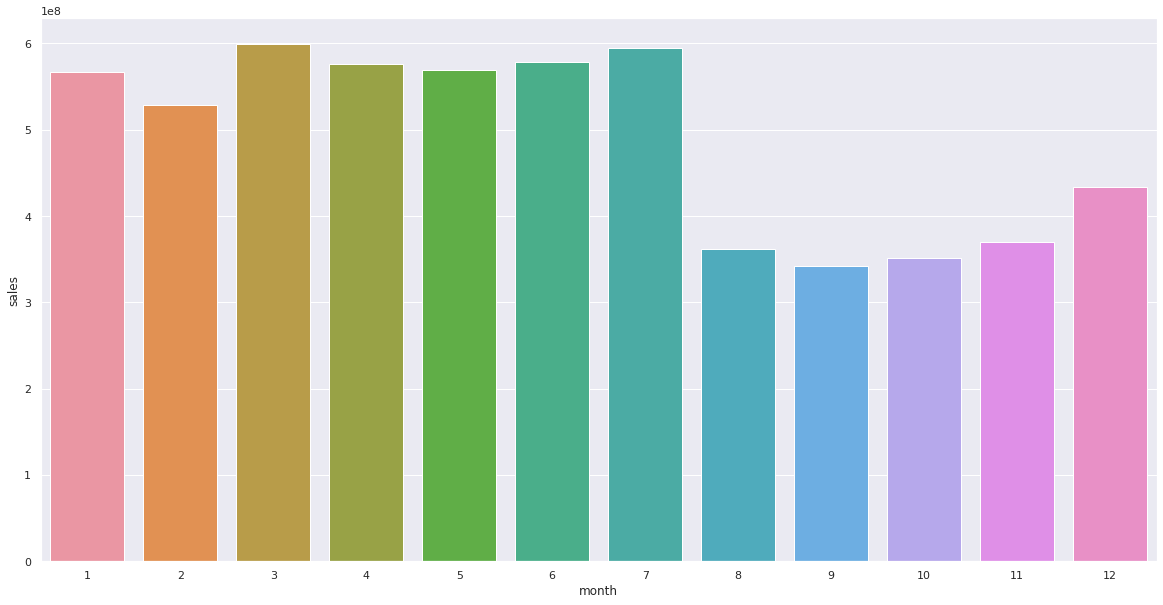

In [38]:
aux = df4[['sales','month']].groupby('month').sum().reset_index()
sns.barplot(x='month',y='sales',data=aux);

### **H10.** Lojas deveriam vender mais no segundo semestre do ano
**Falsa** Lojas vendem menos no segundo semestre do ano

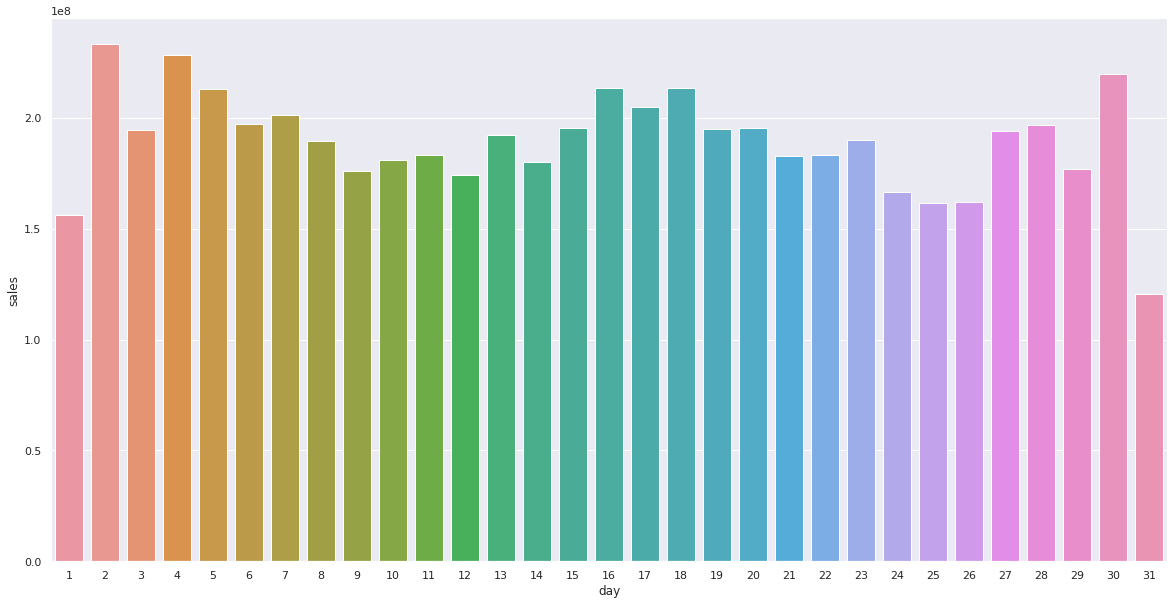

In [39]:
aux = df4[['sales','day']].groupby('day').sum().reset_index()
sns.barplot(x='day',y='sales',data=aux);

## Análise Multivariada

### Numerical Attributes

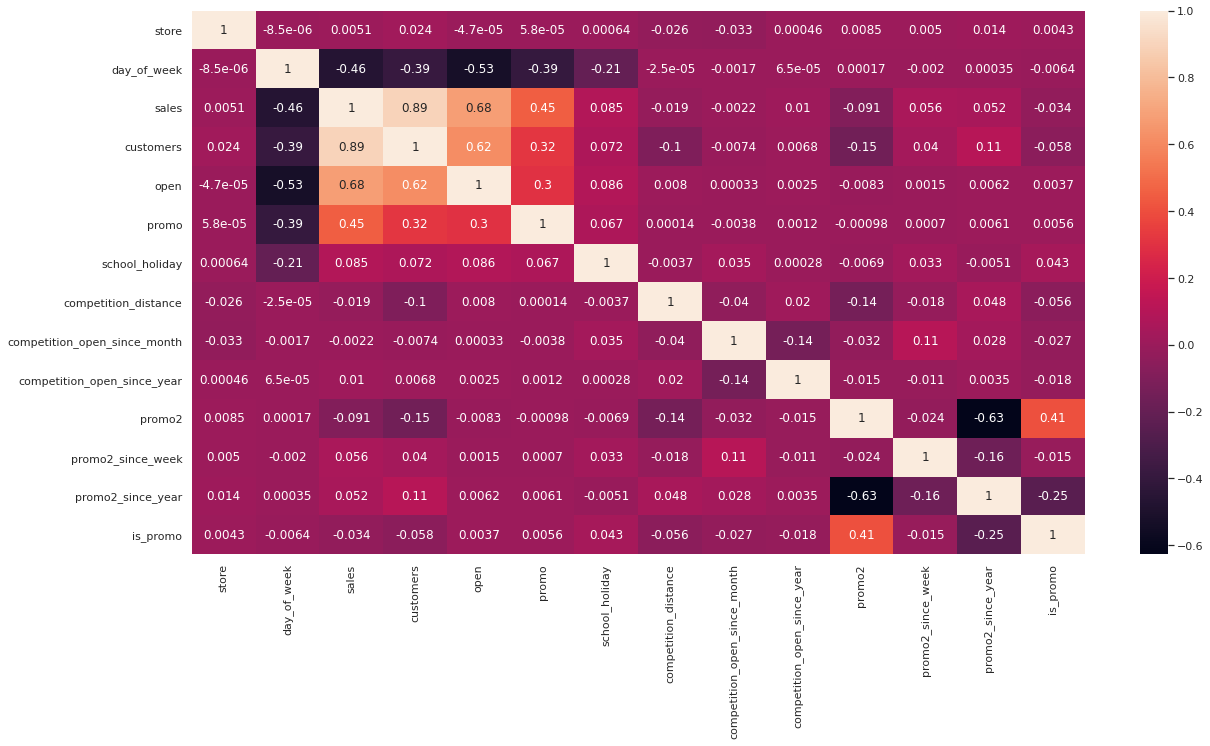

In [40]:
aux = num_atributtes.corr(method='pearson')
sns.heatmap(aux, annot=True);

### Categoy attributes

In [41]:
# Cria o dataframe com as variáveis categóricas
cat = df4.select_dtypes(include='object')

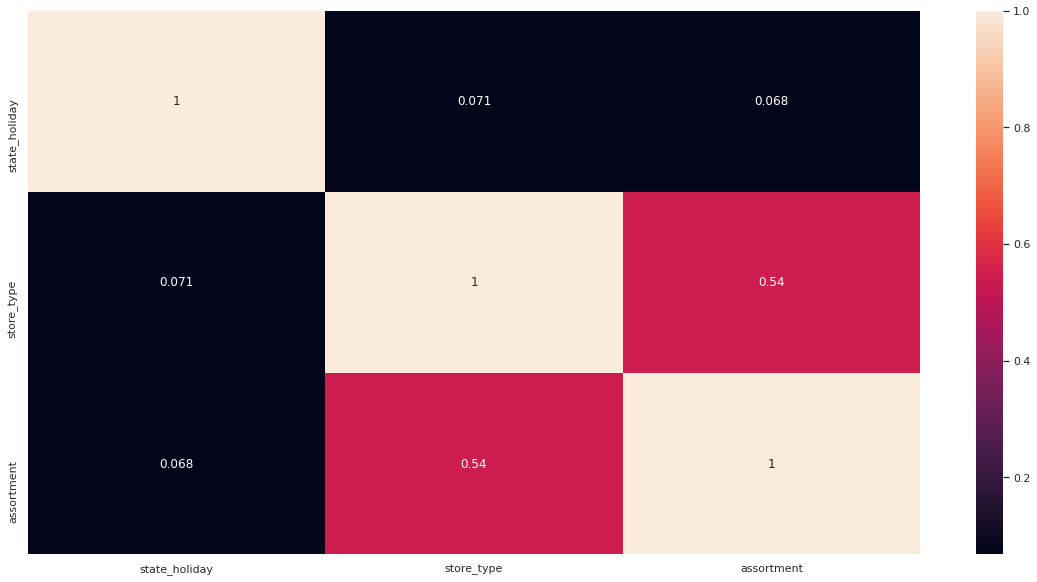

In [42]:
# Calculamos os valores da correlação de cada variável
# - criada a funcao cramer_v
a1 = cramer_v(cat['state_holiday'],cat['state_holiday'])
a2 = cramer_v(cat['state_holiday'],cat['store_type'])
a3 = cramer_v(cat['state_holiday'],cat['assortment'])
 
a4 = cramer_v(cat['store_type'],cat['state_holiday'])
a5 = cramer_v(cat['store_type'],cat['store_type'])
a6 = cramer_v(cat['store_type'],cat['assortment'])

a7 = cramer_v(cat['assortment'],cat['state_holiday'])
a8 = cramer_v(cat['assortment'],cat['store_type'])
a9 = cramer_v(cat['assortment'],cat['assortment'])


# Cria o dataframe com a matriz
d = pd.DataFrame({'state_holiday': [a1,a2,a3], 
                  'store_type': [a4,a5,a6], 
                  'assortment': [a7,a8,a9] })

# seta o index com as colunas
d = d.set_index(d.columns)

# Cria o heatmap
sns.heatmap(d, annot=True);

# DATA PREPARATION

In [43]:
df5 = df4.copy()

## Rescaling  (min-max ou Robust scaler)

In [44]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl','wb' ) )

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('../parameter/year_scaler.pkl','wb' ) )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl','wb' ) )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('../parameter/promo_time_week_scaler.pkl','wb' ) )

## Transformação (encode)

### Encoding

In [45]:
# state_holiday (one hot enconding)
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type (label enconder)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open('../parameter/store_type_scaler.pkl','wb'))

# assortment 
assortment_dict =  {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### Response variable transformation

In [46]:
df5['sales'] = np.log1p(df5['sales'])

### Nature transformation

In [47]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7)))

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30)))

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52)))


# FEATURE SELECTION

In [48]:
df6 = df5.copy()

## Split dataframe into training and test dataset

- Separar os dados de treino e teste para não ter overfitting no modelo

In [49]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [50]:
data_de_6semanas = df6[['date','store']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7)

In [51]:
# dataset training
X_train = df6[df6['date'] < data_de_6semanas]
y_train = X_train['sales']

# dataset test
X_test = df6[df6['date'] >= data_de_6semanas]
y_test = X_test['sales']

print('Date training min: {}'.format(X_train['date'].min()))
print('Date training max: {}'.format(X_train['date'].max()))

print('\nDate test min: {}'.format(X_test['date'].min()))
print('Date test max: {}'.format(X_test['date'].max()))

Date training min: 2013-01-01 00:00:00
Date training max: 2015-06-18 00:00:00

Date test min: 2015-06-19 00:00:00
Date test max: 2015-07-31 00:00:00


## Boruta as Feature Selector
- Devido a falta de memória para rodar o boruta, esse trecho foi comentado

In [ ]:
# define Random Forest Regressor
rf = RandomForestRegressor(n_jobs=1)

# define test and train for boruta
X_train_n = X_train.drop(['date','sales'],axis=1).values
y_train_n = y_train.values.ravel()

# define BorutaPy
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

### Best Features From Boruta

In [ ]:
# pega as features escolhidas pelo boruta
cols_selected = boruta.support_.tolist()

# cria um novo data frame só com as features analisadas
x_train_fs = X_train.drop(['date','sales'], axis=1)

# cria um data frame só com as colunas selecionadas pelo boruta
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

# colunas não selecionadas pelo boruta
cols_not_selected_boruta = list(np.setdiff1d ( x_train_fs.columns, cols_selected_boruta ))

## Manual Feature Selected

In [52]:
cols_selected_boruta_manual= [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_cos'
]

## adiciona colunas
feat_to_add = ['date','sales']
cols_selected_boruta_full = cols_selected_boruta_manual.copy()
cols_selected_boruta_full.extend(feat_to_add)

# MACHINE LEARNING MODELING

In [53]:
# criar os dados de treino e teste com as colunas selecionadas pelo boruta
x_train = X_train[cols_selected_boruta_manual]
x_test = X_test[cols_selected_boruta_manual]

# crossvalidation
xtraining = X_train[cols_selected_boruta_full]

## Average Model - baseline

In [62]:
# criar uma baseline com base na média
# cria um dataframe auxiliar para gerar a coluna de predições com base na média
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline =  aux1['predictions']

# perfomance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

Model name:         Mae:   Mape:        RMSE: 
0  Average Model  1354.800353  0.2064  1835.135542

## Linear Regression Model

In [63]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test),np.expm1(yhat_lr))
lr_result

Model name:         Mae:     Mape:        RMSE: 
0  Linear Regression  1875.542871  0.295977  2669.284167

### Linear Regression Model - Cross Validation

In [64]:
lr_result_cross = cross_validation(xtraining,5,"Linear Regression",lr)
lr_result_cross

Model Name               MAE CV       MAPE CV             RMSE CV
0  Linear Regression  2081.79 +/- 302.95  0.3 +/- 0.01  2959.45 +/- 473.15

## Linear Regression Regularized Model

In [65]:
# Model
lrs = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrs = lrs.predict(x_test)

# performance
lrs_result = ml_error('Lasso', np.expm1(y_test),np.expm1(yhat_lrs))
lr_result

Model name:         Mae:     Mape:        RMSE: 
0  Linear Regression  1875.542871  0.295977  2669.284167

### Lasso - Cross Validation

In [66]:
lrs_result_cross = cross_validation(xtraining,5,"Lasso",lrs)
lrs_result_cross

Model Name               MAE CV        MAPE CV            RMSE CV
0       Lasso  2118.73 +/- 341.76  0.29 +/- 0.01  3059.92 +/- 504.1

## Random Forest Regressor Model

In [ ]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test),np.expm1(yhat_rf))
rf_result

### Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cross = cross_validation(xtraining,5,"Random Forest Regressor",rf)
rf_result_cross

## XGBoost Regressor Model

In [ ]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01,
                             max_depth = 10,
                             colsample_bytree=0.9,
                             subsample = 0.7).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBRegressor', np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result

### XGBosst Regressor - Cross Validation

In [ ]:
xgb_result_cross = cross_validation(xtraining,5,"XGBoost Regressor",model_xgb)
xgb_result_cross

## Compare model's performance

### Single performance

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrs_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE: ')

### Real perfomance - Cross validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cross,lrs_result_cross, rf_result_cross, xgb_result_cross])
modelling_result_cv.sort_values('RMSE CV')

# HYPERPARAMETER FINE TUNING

## Randon Search

In [ ]:
import random

In [ ]:
param = {
    'n_estimators':[1500,1700,2500,3500],
    'eta':[0.01,0.03],
    'max_depth':[3,5,9],
    'colsample_bytree':[0.1,0.5,0.7],
    'subsample':[0.3,0.7,0.9],
    'min_child_weight':[3,8,15]
}

MAX_EVAL = 10

In [ ]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose parameters
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)
    
    # model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators = hp['n_estimators'], 
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 colsample_bytree = hp['colsample_bytree'],
                                 subsample = hp['subsample'],
                                 min_child_weight = hp['min_child_weight'])

    # performance
    result = cross_validation(xtraining,5,'XGBoost Regressor', model_xgb)
    final_result = pd.concat([final_result, result])

final_result

## Final Model

In [ ]:
# Melhores valores de parâmetros encontrado
param_tuned = {
    'n_estimators':3000,
    'eta':0.03,
    'max_depth':5,
    'colsample_bytree':0.7,
    'subsample':0.7,
    'min_child_weight':3
}

In [ ]:
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators = param_tuned['n_estimators'], 
                                 eta = param_tuned['eta'],
                                 max_depth = param_tuned['max_depth'],
                                 colsample_bytree = param_tuned['colsample_bytree'],
                                 subsample = param_tuned['subsample'],
                                 min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb.predict(x_test)
    
# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

In [54]:
model_pickle = pickle.load(open('../model/model_rossmann.pkl', 'rb'))
yhat_xgb_tuned = model_pickle.predict(x_test)

# TRADUÇÃO E INTERPRETAÇÃO DO ERRO


In [55]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## Business performance

In [56]:
# sum predictions
df91 =  df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales','predictions']].groupby('store').apply( lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename( columns={ 0:'MAE'})
df9_aux2 = df9[['store', 'sales','predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename( columns={ 0:'MAPE'})

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

In [57]:
df92['worst scenario'] = df92['predictions'] -  df92['MAE']
df92['best scenario'] = df92['predictions'] +  df92['MAE']
df92 = df92[['store', 'predictions','worst scenario','best scenario','MAE','MAPE']]
df92

store    predictions  worst scenario  best scenario          MAE      MAPE
0         1  169510.687500   169190.894802  169830.480198   319.792698  0.074728
1         2  183813.812500   183355.134541  184272.490459   458.677959  0.091299
2         3  276080.000000   275281.764714  276878.235286   798.235286  0.114642
3         4  354500.250000   353692.935626  355307.564374   807.314374  0.077394
4         5  172487.312500   172104.526915  172870.098085   382.785585  0.083513
...     ...            ...             ...            ...          ...       ...
1110   1111  183188.421875   182490.519412  183886.324338   697.902463  0.158207
1111   1112  341539.250000   340465.148266  342613.351734  1074.101734  0.130278
1112   1113  249852.109375   249258.756255  250445.462495   593.353120  0.092223
1113   1114  792142.812500   790209.521748  794076.103252  1933.290752  0.083240
1114   1115  258340.031250   257693.484137  258986.578363   646.547113  0.089273

[1115 rows x 6 columns]

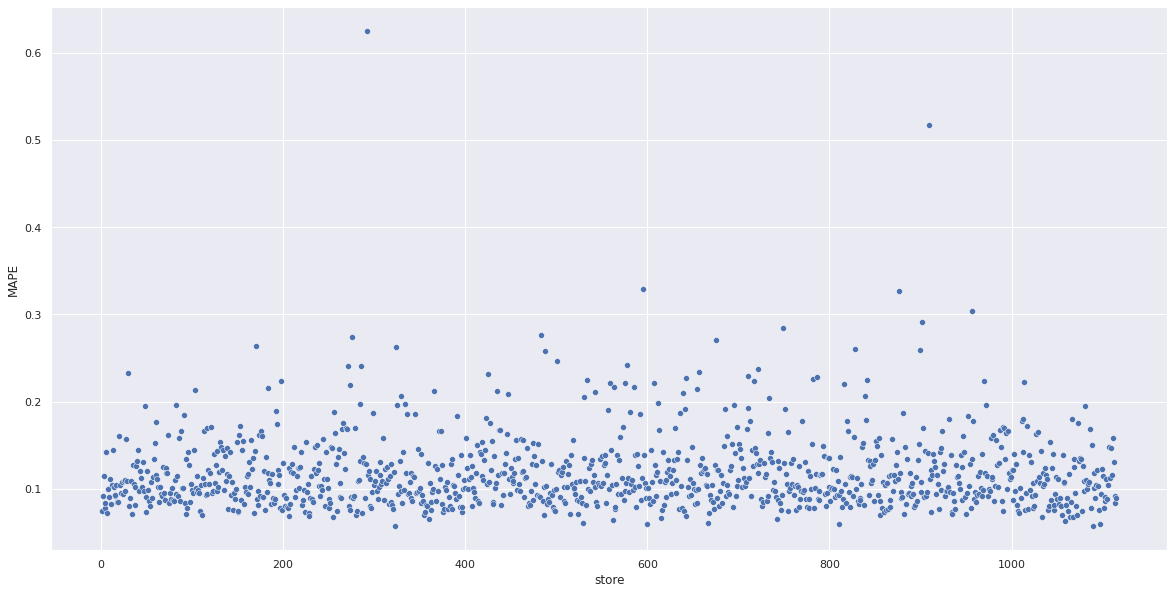

In [58]:
sns.scatterplot(x=df92['store'], y=df92['MAPE']);

## Total Performance

In [59]:
df93 = df92[['predictions','worst scenario','best scenario']].apply( lambda x: np.sum(x)).reset_index().rename(columns={'index':'scenarios', 0:'values'})
df93['values'] = df93['values'].map('R$ {:,.2f}'.format)
df93

scenarios             values
0     predictions  R$ 289,257,792.00
1  worst scenario  R$ 288,387,113.61
2   best scenario  R$ 290,128,419.86

## Machine Learning Performance

In [60]:
df9['error'] = df9['sales'] - df9['predictions'] 
df9['error_rate'] = df9['predictions'] / df9['sales']

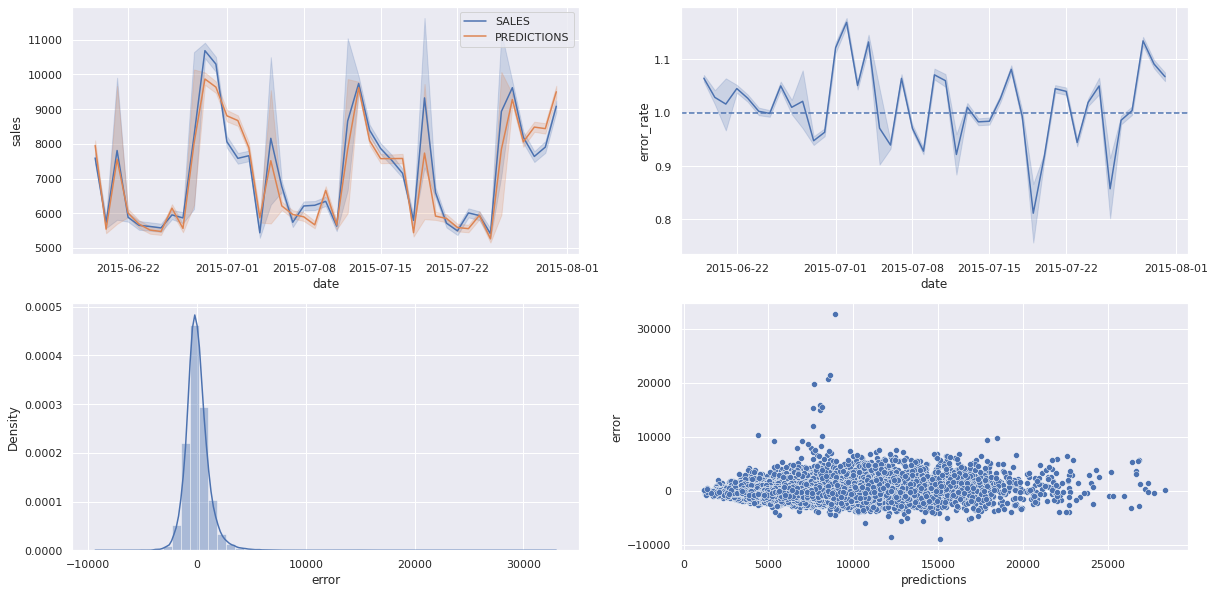

In [61]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales', data=df9, label='SALES')
sns.lineplot(x='date',y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate', data=df9)
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x='predictions', y='error',data=df9);

# DEPLOY MODEL FOR PRODUCTION


In [ ]:
# Cria o arquivo binário (pickle) do modelo XGBoost para produção
filename = 'nps-rossmann-store-sales/model/model_rossmann.pkl'
pickle.dump(model_xgb, open(filename,'wb'))